<a href="https://colab.research.google.com/github/Louis5228/2020-Machine-Learning/blob/main/hw3_309512014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import cv2
from numpy.linalg import inv, pinv, linalg
drive.mount('/content/gdrive')

x_data = pd.read_csv("/content/gdrive/My Drive/Machine_Learning/HW3/dataset/gp_x.csv", header=None)
t_data = pd.read_csv("/content/gdrive/My Drive/Machine_Learning/HW3/dataset/gp_t.csv", header=None)

x_data = np.array(x_data)
t_data = np.array(t_data)

# 1. Gaussian Process for Regression

In [333]:
Num = 50
x_train = x_data[:Num]
t_train = t_data[:Num]
x_test = x_data[Num:]
t_test = t_data[Num:]

theta_config = [[0,  0,  0, 1],
                [1, 16,  0, 0],
                [1, 16,  0, 4],
                [1, 64, 32, 0],
                [8, 256, 0, 0]] # trial and error config
beta_inv = 1

In [334]:
def cal_ker(theta, xn, xm):
  return theta[0] * math.exp(-theta[1]*0.5 * (xn - xm)**2) + theta[2] + theta[3] * xn * xm

def cal_Gaussian(thera, xn, cov_inv):
  k = np.zeros((Num,1))
  for i in range(Num):
    k[i,0] = cal_ker(theta, x_train[i], xn)
  c = cal_ker(theta, xn, xn) + beta_inv
  mean = (k.T).dot(cov_inv).dot(t_train)
  var = c - (k.T).dot(cov_inv).dot(k)
  return mean, var

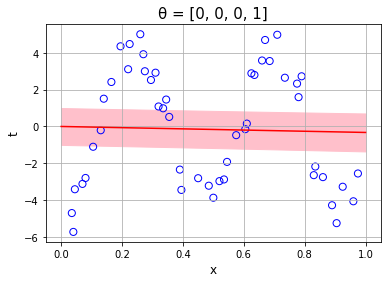

RMS error of training data : 3.1292014298222433
RMS error of testing  data : 3.3443986601861155
--------------------------------------------------


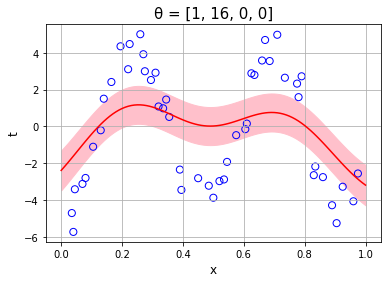

RMS error of training data : 2.4239279278312194
RMS error of testing  data : 2.6680517502524466
--------------------------------------------------


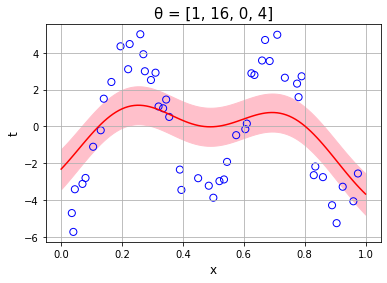

RMS error of training data : 2.4105764871252062
RMS error of testing  data : 2.6569980001669147
--------------------------------------------------


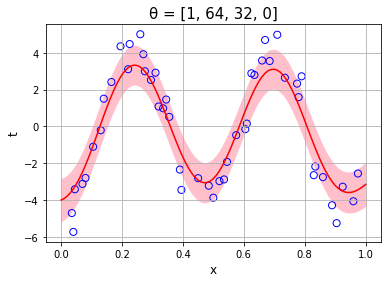

RMS error of training data : 1.0428861621832066
RMS error of testing  data : 1.1627590936118535
--------------------------------------------------


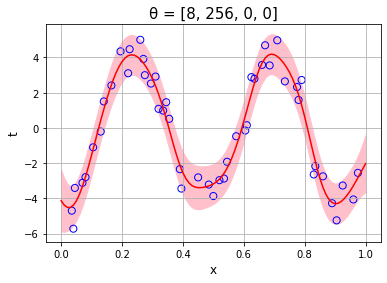

RMS error of training data : 0.6727647429593002
RMS error of testing  data : 1.041155920423071
--------------------------------------------------


In [335]:
x = np.arange(0, 1.01, 0.01)

for theta in theta_config:
  y = np.zeros(0)
  std = np.zeros(0)
  cov = np.zeros((Num, Num))
  for i in range(Num):
    for j in range(Num):
      cov[i,j] = cal_ker(theta, x_train[i], x_train[j])
      if i == j:
        cov[i,j] += beta_inv
  cov_inv = inv(cov)

  for xn in x:
    mean, var = cal_Gaussian(theta, xn, cov_inv)
    y = np.append(y, mean)
    std = np.append(std, math.sqrt(var))
  
  RMS_err_train = 0
  for i in range(Num):
    mean, var = cal_Gaussian(theta, x_train[i], cov_inv)
    RMS_err_train += (mean - t_train[i])**2
  RMS_err_train = math.sqrt(RMS_err_train / Num)

  RMS_err_test = 0
  for i in range(x_data.shape[0] - Num):
    mean, var = cal_Gaussian(theta, x_test[i], cov_inv)
    RMS_err_test += (mean - t_test[i])**2
  RMS_err_test = math.sqrt(RMS_err_test / (x_data.shape[0] - Num))

  plt.plot(x, y, c='r')    
  plt.fill_between(x, y - std, y + std, color='pink')
  plt.scatter(x_train, t_train, s=50, facecolors='none', edgecolors='b')
  plt.title("θ = " + str(theta), fontsize = 15)
  plt.xlabel("x", fontsize = 12)
  plt.ylabel("t", fontsize = 12)
  plt.grid(True)
  plt.show()
  print("RMS error of training data : " + str(RMS_err_train))
  print("RMS error of testing  data : " + str(RMS_err_test))
  print("-"*50)

# 2. Support Vector Machine ( SVM )

# 3. Gaussian Mixture Model